In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [3]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/07_SVB_febTS_dwnw/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)


In [4]:
depth_bay = ds.Depth[:]
LAT = ds['YC'][:]
LON = ds['XC'][:]-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

Z = ds['Z'][:]
Zl = ds['Zl'][:]

# centers mask
hFacC = ds['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_bay,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

In [5]:
def get_snapshot_at_level(ds,tt,zz,fld):
    W = ds[fld][tt,zz,:,:]
    return(W)

def get_eta_snapshot(ds,tt,fld):
    W = ds[fld][tt,:,:]
    return(W)

def plot_field_w(ax,tt,lon,lat,eta,time,mask,zind,
                 cmap=cmo.cm.rain,vmin=-0.3, vmax=0.3, title=' ', cbar=False):
    ax.set_facecolor('tan')
    levs = np.linspace(vmin,vmax,60)
    pc = ax.contourf(lon,lat, 
                     np.ma.masked_array(eta,mask=mask[zind,:,:]),
                     levels=levs,
                     cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
      
    if cbar==True:
        cbar_ax = fig.add_axes([0.35, 0.82, 0.5, 0.04]) 
        cb = fig.colorbar(pc,
                          cax=cbar_ax, orientation='horizontal', 
                          format='%1.1f', label='cm',
                          extend='both', ticks=[-1.2,-0.8,-0.4,0,0.4,0.8,1.2])
    
        #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        #cbar_ax = fig.add_axes([0.45, 0.8, 0.38, 0.05]) 
        #cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        #                  cax=cbar_ax, orientation='horizontal', 
        #                  format='%1.1f', label='SSH (cm)')
    
    ax.set_title('%s t=%1.1f h'%(title,time[tt]/3600))
    ax.set_aspect(1)
    return(ax)

def init():
    tt=0
    Wbay1 = get_eta_snapshot(ds, tt, 'ETAN')
     
    axx= plot_field_w(ax1,tt,lon,lat,(Wbay1)*1E2,time,
                      mask,zz,cmap=cmap, vmin=-1.2, vmax=1.2,cbar=True, title='SSH at SVB')
    ax1.contour(lon, lat, depth_bay, levels=[0, 200, 400, 600, 800, 1000],
                colors=['0.5','0.5','0.5','0.5','0.5','0.5'], alpha=0.1)
    
    ax1.set_xlabel('lon')
    ax1.set_ylabel('lat')
   
def animate(t):
    tt=t
    #tt=t
    print(tt)
    Wbay1 = get_eta_snapshot(ds, tt, 'ETAN')
        
    axx= plot_field_w(ax1,tt,lon,lat,(Wbay1)*1E2,
                      time,mask,zz,cmap=cmap, vmin=-1.2, vmax=1.2, title='SSH at SVB')
    ax1.set_xticks([-116,-115.5,-115,-114.5,-114])
    ax1.set_xlabel('lon')
    ax1.set_ylabel('lat')

In [6]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, metadata=dict(artist='KRM'), bitrate=300)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


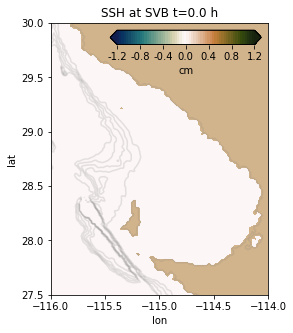

In [7]:
cmap=cmo.cm.tarn_r
zz = 0
fig, ax1 = plt.subplots(1,1, figsize=(4.2,5))
ax1.set_xlim(-116, -114)
ax1.set_ylim(27.5, 30)
# Uncomment lines below to run and save animation
anim = animation.FuncAnimation(fig, animate, init_func=init, blit=False,
                               frames=144, repeat=False)
anim.save('SVB_seiche_downwelling.mov', writer=writer, dpi=500)

In [ ]:
tt=23
plt.pcolormesh(lon,lat,ds['ETAN'][tt,:,:], cmap=cmo.cm.tarn)
plt.xlim(-116,-114)
plt.ylim(27.5,30)
plt.title('%1.1f' %(time[tt]/3600))